In [12]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [2]:
%matplotlib notebook

In [62]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [73]:
#model00=pesca_base.PescaButano.load("run_tide_test")
model01=pesca_base.PescaButano.load('run_tide_test-v01')
#model02=pesca_base.PescaButano.load('run_tide_test-v02')
#model03=pesca_base.PescaButano.load('run_tide_test-v03')
#model04=pesca_base.PescaButano.load('run_tide_test-v04')
#model05=pesca_base.PescaButano.load('run_tide_test-v05')
model06=pesca_base.PescaButano.load('run_tide_test-v06')


<IPython.core.display.Javascript object>


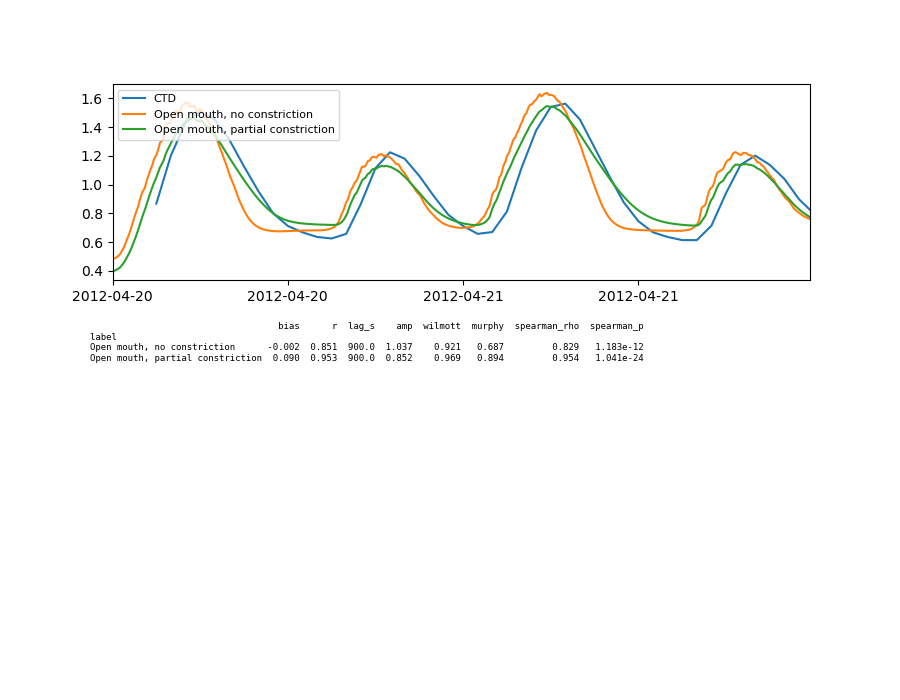

/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/general/

In [84]:
import six
six.moves.reload_module(dc)

sources=[observed]

for model in [model01,model06]:
    his_ds=xr.open_dataset(model.his_output())

    predicted=his_ds['waterlevel'].isel(stations=np.nonzero( his_ds['station_name'].values==b'lag1' )[0][0])
    predicted=predicted.assign_coords(label=f'{model.run_dir} (lag1)')
    sources.append(predicted)
    his_ds.close()

observed=esa_waterlevel['waterlevel'].assign_coords(label="CTD")

sources[1]['label']=(),'Open mouth, no constriction'
sources[2]['label']=(),'Open mouth, partial constriction'
fig=dc.calibration_figure_3panel(sources,trim_time=True,lowpass=False,metric_x='all')
fig.axes[2].set_visible(0)

In [17]:
his_ds

'run_tide_test-v01/DFM_OUTPUT_flowfm/flowfm_0000_his.nc'

In [ ]:
## 
plt.figure(1).clf()
fig,ax=plt.subplots(num=1)
ax.plot(predicted.time,predicted,label='Model')

sel=slice(*np.searchsorted( esa_waterlevel.time.values,
                            [predicted.time.values[0], predicted.time.values[-1]] ))

esa_select=esa_waterlevel.waterlevel.isel(time=sel)
ax.plot(esa_select.time-np.timedelta64(3600,'s'),
        esa_select,label='ESA compiled\nobservations')
ax.legend(loc='upper right')

ax.set_ylabel('water level (m NAVD88)')

##
plt.figure(2).clf()
plt.plot( esa_waterlevel.time, esa_waterlevel.waterlevel)

plt.show()